In [33]:
!pip install pmdarima

In [34]:
from datetime import datetime, timedelta, timezone
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.cluster import KMeans
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error,mean_absolute_error, classification_report, r2_score, accuracy_score, mean_absolute_percentage_error
import pmdarima as pm
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.tsa.api import SARIMAX


#setting default plot size
from pylab import rcParams
#ignore future warnings to have clean output
import warnings
rcParams['figure.figsize'] = 18, 8
pd.options.mode.chained_assignment = None
warnings.simplefilter(action='ignore', category=FutureWarning)


In [35]:
def get_df_index(df, h=0, freq='1T'):
    """
    Get the date/time range of the dataset from UNIX timestamps

    df: The dataset containing the data
    h: the hours difference from UTC
    frequency: the frequency of the measurements
    """
    start_time = datetime.fromtimestamp(int(df['time'].iloc[0]), timezone(timedelta(hours=h))).strftime('%Y-%m-%d %H:%M')
    end_time = datetime.fromtimestamp(int(df['time'].iloc[-1]), timezone(timedelta(hours=h))).strftime('%Y-%m-%d %H:%M')
    minute_index = pd.date_range(start_time, periods=len(home_dataset), freq=freq) # instruction say frequency is 1 minute
    return minute_index

def resample_dataframe(df, energy_consumption_cols, energy_generation_cols, weather_cols_cont, weather_cols_cat, freq):
    """
    Resample dataframe to appropriate frequency

    df: The dataframe containing the data we want to resample
    energy_consumption_cols: the columns containing variables related to energy consumption
    energy_generation_cols: the columns containing variables related to energy generation
    weather_cols_cont: the columns containing continuous weather variables
    weather_cols_cat: the columns containing categorical weather variables
    freq: the resampling frequency
    """
    energy_tmp = energy_consumption_cols + energy_generation_cols

    # Energy is summed up (total energy per day)
    home_dataset_energy_day = df[energy_tmp].resample(freq, closed='left', label='left').sum()

    # Weather information is averaged/we keep the most common
    home_dataset_weather_day_cont = df[weather_cols_cont].resample(freq, closed='left', label='left').mean()
    home_dataset_weather_day_cat = df[weather_cols_cat].resample(freq, closed='left', label='left').apply(lambda x: x.value_counts().idxmax())

    home_dataset_day = pd.concat([home_dataset_energy_day, home_dataset_weather_day_cont, home_dataset_weather_day_cat], axis=1)
    return home_dataset_day

def plot_predicted_values(pred_col):
    """
    Create plots of observed and predicted values

    pred_col: The column in the dataframe where the prediction is stored
    """
    sns.lineplot(x=time_index_train, y='Consumed energy', data=train_set, label='train set')
    sns.lineplot(x=time_index_test, y='Consumed energy', data=test_set, label='test set - observed')
    sns.lineplot(x=time_index_train, y=pred_col, data=train_set, label='train set - predicted')
    sns.lineplot(x=time_index_test, y=pred_col, data=test_set, label='test set - predicted')
    plt.ylabel('Consumed energy [kW]')
    plt.title(f'10-day energy consumption prediction using model {pred_col}')
    plt.show()

In [36]:
home_dataset = pd.read_csv("HomeC[1].csv")
print(f'The shape of the dataset is {home_dataset.shape}')
display(home_dataset.head())

# What are the columns and their types?
print(f'The column names of the dataset are')
display(home_dataset.columns)

print(f'The types of the dataset are')
display(home_dataset.dtypes)

# Check if there are entries with null values
display(home_dataset.info())
home_dataset[home_dataset.isnull().any(axis=1)]

# Drop the line with missing values
home_dataset.dropna(inplace=True)

<ipython-input-36-4f29cea7a32b>:1: DtypeWarning: Columns (0,27) have mixed types. Specify dtype option on import or set low_memory=False.
  home_dataset = pd.read_csv("HomeC[1].csv")


The shape of the dataset is (503911, 32)


,time,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],...,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
0,1451624400,0.932833,0.003483,0.932833,0.000033,0.020700,0.061917,0.442633,0.124150,0.006983,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
1,1451624401,0.934333,0.003467,0.934333,0.000000,0.020717,0.063817,0.444067,0.124000,0.006983,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
2,1451624402,0.931817,0.003467,0.931817,0.000017,0.020700,0.062317,0.446067,0.123533,0.006983,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
3,1451624403,1.022050,0.003483,1.022050,0.000017,0.106900,0.068517,0.446583,0.123133,0.006983,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
4,1451624404,1.139400,0.003467,1.139400,0.000133,0.236933,0.063983,0.446533,0.122850,0.006850,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0


The column names of the dataset are


Index(['time', 'use [kW]', 'gen [kW]', 'House overall [kW]', 'Dishwasher [kW]',
       'Furnace 1 [kW]', 'Furnace 2 [kW]', 'Home office [kW]', 'Fridge [kW]',
       'Wine cellar [kW]', 'Garage door [kW]', 'Kitchen 12 [kW]',
       'Kitchen 14 [kW]', 'Kitchen 38 [kW]', 'Barn [kW]', 'Well [kW]',
       'Microwave [kW]', 'Living room [kW]', 'Solar [kW]', 'temperature',
       'icon', 'humidity', 'visibility', 'summary', 'apparentTemperature',
       'pressure', 'windSpeed', 'cloudCover', 'windBearing', 'precipIntensity',
       'dewPoint', 'precipProbability'],
      dtype='object')

The types of the dataset are


,0
time,object
use [kW],float64
gen [kW],float64
House overall [kW],float64
Dishwasher [kW],float64
Furnace 1 [kW],float64
Furnace 2 [kW],float64
Home office [kW],float64
Fridge [kW],float64
Wine cellar [kW],float64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 503911 entries, 0 to 503910
Data columns (total 32 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   time                 503911 non-null  object 
 1   use [kW]             503910 non-null  float64
 2   gen [kW]             503910 non-null  float64
 3   House overall [kW]   503910 non-null  float64
 4   Dishwasher [kW]      503910 non-null  float64
 5   Furnace 1 [kW]       503910 non-null  float64
 6   Furnace 2 [kW]       503910 non-null  float64
 7   Home office [kW]     503910 non-null  float64
 8   Fridge [kW]          503910 non-null  float64
 9   Wine cellar [kW]     503910 non-null  float64
 10  Garage door [kW]     503910 non-null  float64
 11  Kitchen 12 [kW]      503910 non-null  float64
 12  Kitchen 14 [kW]      503910 non-null  float64
 13  Kitchen 38 [kW]      503910 non-null  float64
 14  Barn [kW]            503910 non-null  float64
 15  Well [kW]        

None

In [37]:
# Print unique values for each column
obj_cols = ['icon', 'summary', 'cloudCover']
for i in obj_cols:
    print(f'{i} takes the following unique values {home_dataset[i].unique()}')

icon takes the following unique values ['clear-night' 'partly-cloudy-night' 'clear-day' 'cloudy'
 'partly-cloudy-day' 'rain' 'snow' 'wind' 'fog']
summary takes the following unique values ['Clear' 'Mostly Cloudy' 'Overcast' 'Partly Cloudy' 'Drizzle' 'Light Rain'
 'Rain' 'Light Snow' 'Flurries' 'Breezy' 'Snow' 'Rain and Breezy' 'Foggy'
 'Breezy and Mostly Cloudy' 'Breezy and Partly Cloudy'
 'Flurries and Breezy' 'Dry' 'Heavy Snow']
cloudCover takes the following unique values ['cloudCover' '0.75' '0' '1' '0.31' '0.44' '0.13' '0.19' '0.25' '0.16'
 '0.21' '0.15' '0.14' '0.27' '0.28' '0.17' '0.05' '0.1' '0.26' '0.29'
 '0.11' '0.09' '0.12' '0.06' '0.02' '0.08' '0.04' '0.35' '0.22' '0.23'
 '0.54' '0.39' '0.03' '0.07' '0.76' '0.62' '0.18' '0.79' '0.48' '0.24'
 '0.57' 0.24 1.0 0.31 0.28 0.15 0.41 0.1 0.12 0.08 0.09 0.19 0.04 0.05
 0.29 0.27 0.35 0.18 0.06 0.03 0.11 0.14 0.25 0.78 0.0 0.16 0.21 0.23 0.17
 0.75 0.26 0.2 0.76 0.13 0.77 0.46 0.07 0.55 0.02 0.01 0.51 0.47 0.5 0.4
 0.3 0.22 0.43 0.3

In [38]:
# Replace 'cloudCover' with NaN, fill missing values using backward fill, and convert to float
home_dataset[home_dataset['cloudCover']=='cloudCover'].index
home_dataset['cloudCover'].replace('cloudCover', np.nan, inplace=True)
home_dataset['cloudCover'].fillna(method='bfill', inplace=True)
home_dataset['cloudCover'] = home_dataset['cloudCover'].astype('float')

In [39]:
minute_index = get_df_index(home_dataset, h=0, freq='1T')

home_dataset = home_dataset.set_index(minute_index)

# As an example, resample the total use column to get the count of days
day_resample_df = home_dataset['use [kW]'].resample('1d', closed='left', label='right').sum()
day_index = day_resample_df.index
print(f'\nNumber of days is {day_index.shape[0]}\n')
display(day_resample_df.tail())

print(f'\nThe first entry is {home_dataset.index[0]}')
print(f'The last entry is {home_dataset.index[-1]}')


Number of days is 351



,use [kW]
2016-12-13,1617.835017
2016-12-14,1133.408117
2016-12-15,1026.850250
2016-12-16,1508.666433
2016-12-17,273.442767



The first entry is 2016-01-01 05:00:00
The last entry is 2016-12-16 03:29:00


In [41]:
#combining similar columns
home_dataset['Furnace'] = home_dataset['Furnace 1 [kW]'] + home_dataset['Furnace 2 [kW]']
home_dataset['Kitchen'] = home_dataset['Kitchen 12 [kW]'] + home_dataset['Kitchen 14 [kW]'] + home_dataset['Kitchen 38 [kW]']
home_dataset.drop(['time', 'Furnace 1 [kW]', 'Furnace 2 [kW]', 'Kitchen 12 [kW]', 'Kitchen 14 [kW]', 'Kitchen 38 [kW]'], axis =1, inplace=True)

In [42]:
#only keeping relevant rows for correleation matrix
filtered_df=home_dataset.drop(columns=['icon','summary','Garage door [kW]','Wine cellar [kW]','Barn [kW]','Well [kW]','Microwave [kW]'])
filtered_df.dtypes

,0
use [kW],float64
gen [kW],float64
House overall [kW],float64
Dishwasher [kW],float64
Home office [kW],float64
Fridge [kW],float64
Living room [kW],float64
Solar [kW],float64
temperature,float64
humidity,float64


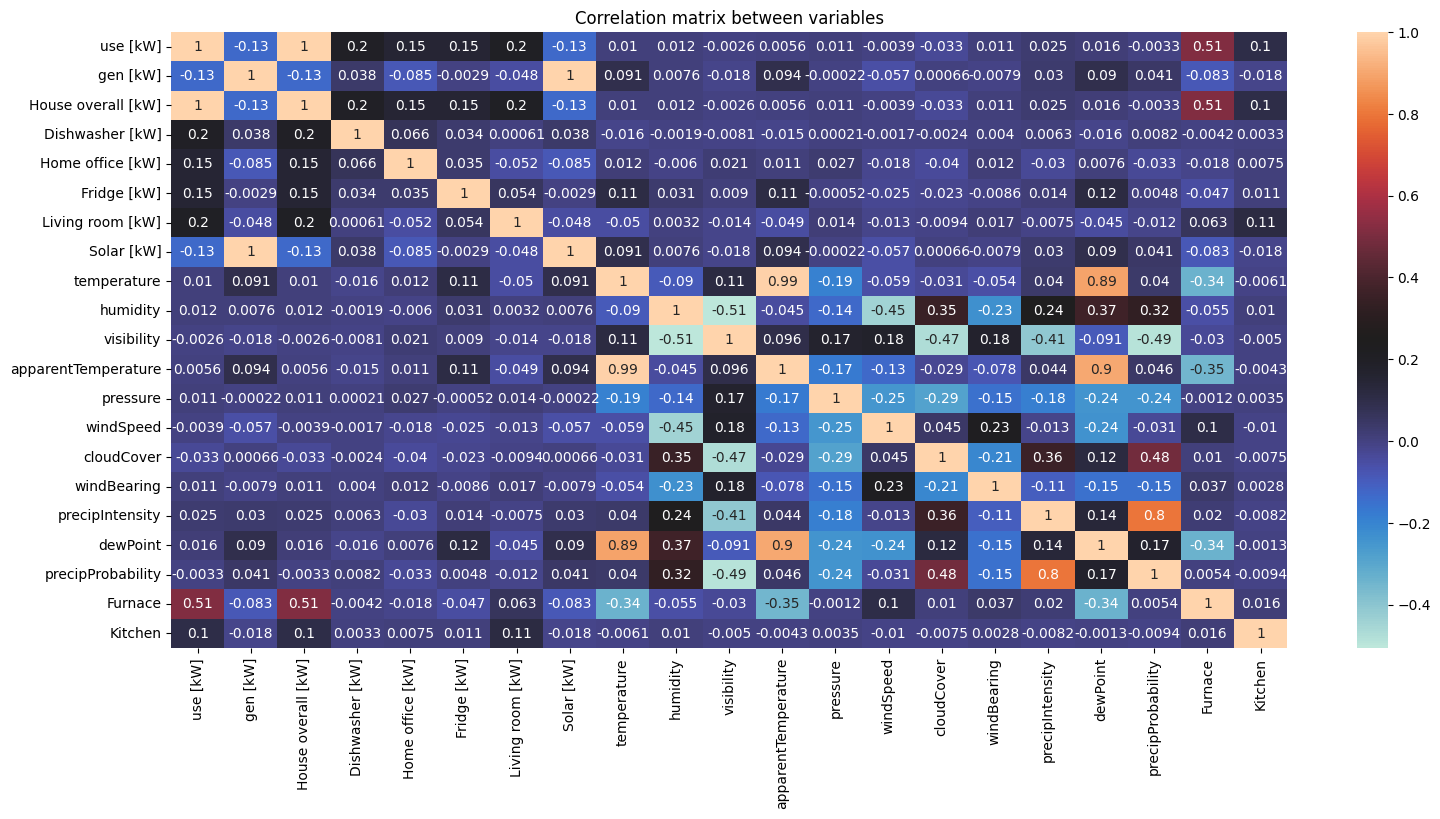

In [43]:
plt.figure()
sns.heatmap(filtered_df.corr(), annot=True, cmap='icefire').set_title('Correlation plot')
plt.title('Correlation matrix between variables')
plt.show()

In [44]:
#correlation function
def correlation(dataset, threshold):
    col_corr = set()
    corr_matrix = filtered_df.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

corr_features = correlation(filtered_df, 0.9)

print(corr_features)

{'dewPoint', 'Solar [kW]', 'House overall [kW]', 'apparentTemperature'}


In [45]:
#droppping correlated features
home_dataset.drop('House overall [kW]', axis=1, inplace=True)
home_dataset.drop('Solar [kW]', axis=1, inplace=True)
home_dataset.drop('apparentTemperature', axis=1, inplace=True)


In [46]:
data=home_dataset.copy()
data.head()

,use [kW],gen [kW],Dishwasher [kW],Home office [kW],Fridge [kW],Wine cellar [kW],Garage door [kW],Barn [kW],Well [kW],Microwave [kW],...,summary,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability,Furnace,Kitchen
2016-01-01 00:00:00,0.932833,0.003483,0.000033,0.442633,0.124150,0.006983,0.013083,0.031350,0.001017,0.004067,...,Clear,1016.91,9.18,0.75,282.0,0.0,24.4,0.0,0.082617,0.000567
2016-01-01 00:01:00,0.934333,0.003467,0.000000,0.444067,0.124000,0.006983,0.013117,0.031500,0.001017,0.004067,...,Clear,1016.91,9.18,0.75,282.0,0.0,24.4,0.0,0.084533,0.000567
2016-01-01 00:02:00,0.931817,0.003467,0.000017,0.446067,0.123533,0.006983,0.013083,0.031517,0.001000,0.004067,...,Clear,1016.91,9.18,0.75,282.0,0.0,24.4,0.0,0.083017,0.000617
2016-01-01 00:03:00,1.022050,0.003483,0.000017,0.446583,0.123133,0.006983,0.013000,0.031500,0.001017,0.004067,...,Clear,1016.91,9.18,0.75,282.0,0.0,24.4,0.0,0.175417,0.000650
2016-01-01 00:04:00,1.139400,0.003467,0.000133,0.446533,0.122850,0.006850,0.012783,0.031500,0.001017,0.004067,...,Clear,1016.91,9.18,0.75,282.0,0.0,24.4,0.0,0.300917,0.000783


In [47]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
#separating indepedent features
X = data.drop(columns=['use [kW]'])
y = data['use [kW]']
#one hot encoding icon and summary columns
X['icon'] = X['icon'].astype(str)
X['summary'] = X['summary'].astype(str)
X = pd.get_dummies(X, columns=['icon','summary'])
X = X.apply(pd.to_numeric, errors='coerce')
X.fillna(X.mean(), inplace=True)
# Replace NaN values with 0 before converting to integers
X = X.astype(float)

# Check the result
print(X.head(10))
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

                     gen [kW]  Dishwasher [kW]  Home office [kW]  Fridge [kW]  \
2016-01-01 00:00:00  0.003483         0.000033          0.442633     0.124150   
2016-01-01 00:01:00  0.003467         0.000000          0.444067     0.124000   
2016-01-01 00:02:00  0.003467         0.000017          0.446067     0.123533   
2016-01-01 00:03:00  0.003483         0.000017          0.446583     0.123133   
2016-01-01 00:04:00  0.003467         0.000133          0.446533     0.122850   
2016-01-01 00:05:00  0.003433         0.000283          0.447033     0.122300   
2016-01-01 00:06:00  0.003450         0.000283          0.443267     0.122050   
2016-01-01 00:07:00  0.003417         0.000250          0.444283     0.121800   
2016-01-01 00:08:00  0.003417         0.000183          0.441467     0.121617   
2016-01-01 00:09:00  0.003417         0.000017          0.438733     0.121633   

                     Wine cellar [kW]  Garage door [kW]  Barn [kW]  Well [kW]  \
2016-01-01 00:00:00        

In [48]:
#scaling the data
scaler = MinMaxScaler()
scaled_data_train = scaler.fit_transform(X_train)
scaled_data_test = scaler.transform(X_test)

# Verify no NaNs or Infs in scaled data
print("NaNs in scaled_data_train:", np.isnan(scaled_data_train).sum())
print("NaNs in scaled_data_test:", np.isnan(scaled_data_test).sum())
print("Infs in scaled_data_train:", np.isinf(scaled_data_train).sum())
print("Infs in scaled_data_test:", np.isinf(scaled_data_test).sum())

NaNs in scaled_data_train: 0
NaNs in scaled_data_test: 0
Infs in scaled_data_train: 0
Infs in scaled_data_test: 0


In [49]:
#renaming columns for readability
cols_names = {
    'use [kW]': 'Consumed energy',
    'gen [kW]': 'Generated energy',
    'temperature': 'Temperature',
    'icon': 'Icon',
    'humidity': 'Humidity',
    'visibility': 'Visibility',
    'summary': 'Summary',
    'pressure': 'Pressure',
    'windSpeed': 'Wind speed',
    'cloudCover': 'Cloud cover',
    'windBearing': 'Wind bearing',
    'precipIntensity': 'Percipitation intensity',
    'dewPoint': 'Dew point',
    'precipProbability': 'Percipitation probability'}

home_dataset.rename(columns=cols_names, inplace=True)
cols_tmp = {k:k.replace(' [kW]','') if ' [kW]' in k else k for k in list(home_dataset.columns)}
home_dataset.rename(columns=cols_tmp, inplace=True)

# Group columns by content and type
energy_consumption_cols = ['Consumed energy', 'Dishwasher', 'Home office',
       'Fridge', 'Wine cellar', 'Garage door', 'Barn', 'Well', 'Microwave',
       'Living room', 'Furnace', 'Kitchen']

energy_generation_cols = ['Generated energy']

weather_cols_cont = ['Temperature', 'Humidity', 'Visibility', 'Pressure', 'Wind speed',
    'Wind bearing', 'Percipitation intensity', 'Dew point', 'Percipitation probability', 'Cloud cover']

weather_cols_cat = ['Summary']

# Create column for Sum of individual consumption
tmp = energy_consumption_cols.copy()
tmp.remove('Consumed energy')
home_dataset["Sum of individual"] = home_dataset[tmp].sum(axis=1)

energy_consumption_cols = energy_consumption_cols + ["Sum of individual"]
del tmp

home_dataset.head()

,Consumed energy,Generated energy,Dishwasher,Home office,Fridge,Wine cellar,Garage door,Barn,Well,Microwave,...,Pressure,Wind speed,Cloud cover,Wind bearing,Percipitation intensity,Dew point,Percipitation probability,Furnace,Kitchen,Sum of individual
2016-01-01 00:00:00,0.932833,0.003483,0.000033,0.442633,0.124150,0.006983,0.013083,0.031350,0.001017,0.004067,...,1016.91,9.18,0.75,282.0,0.0,24.4,0.0,0.082617,0.000567,0.708017
2016-01-01 00:01:00,0.934333,0.003467,0.000000,0.444067,0.124000,0.006983,0.013117,0.031500,0.001017,0.004067,...,1016.91,9.18,0.75,282.0,0.0,24.4,0.0,0.084533,0.000567,0.711500
2016-01-01 00:02:00,0.931817,0.003467,0.000017,0.446067,0.123533,0.006983,0.013083,0.031517,0.001000,0.004067,...,1016.91,9.18,0.75,282.0,0.0,24.4,0.0,0.083017,0.000617,0.711550
2016-01-01 00:03:00,1.022050,0.003483,0.000017,0.446583,0.123133,0.006983,0.013000,0.031500,0.001017,0.004067,...,1016.91,9.18,0.75,282.0,0.0,24.4,0.0,0.175417,0.000650,0.803983
2016-01-01 00:04:00,1.139400,0.003467,0.000133,0.446533,0.122850,0.006850,0.012783,0.031500,0.001017,0.004067,...,1016.91,9.18,0.75,282.0,0.0,24.4,0.0,0.300917,0.000783,0.929017


In [50]:
home_dataset_day = resample_dataframe(home_dataset, energy_consumption_cols, energy_generation_cols, weather_cols_cont, weather_cols_cat, '1d')
time_index = home_dataset_day.index
num_days = time_index.shape[0]
print(f'Number of days is {num_days}')

display(home_dataset_day.head())

Number of days is 350


,Consumed energy,Dishwasher,Home office,Fridge,Wine cellar,Garage door,Barn,Well,Microwave,Living room,...,Humidity,Visibility,Pressure,Wind speed,Wind bearing,Percipitation intensity,Dew point,Percipitation probability,Cloud cover,Summary
2016-01-01,1810.161500,90.702557,144.769717,111.682933,31.257550,19.048300,111.661367,35.580433,18.318750,99.103450,...,0.631417,9.774444,1014.571431,7.473833,265.534722,0.000089,23.502389,0.001611,0.572500,Clear
2016-01-02,1840.842500,85.025519,155.771717,94.898667,24.075917,19.220983,185.617650,34.463667,8.947350,73.505583,...,0.573403,9.988722,1014.266569,7.854611,253.373611,0.000000,18.446958,0.000000,0.266208,Clear
2016-01-03,1571.230283,52.463271,194.758500,72.527317,32.892950,19.554350,146.753567,34.488367,24.122217,29.408333,...,0.646222,9.935014,1009.118792,7.565542,236.936111,0.000000,22.009097,0.000000,0.141875,Clear
2016-01-04,1729.139800,79.997807,162.271567,86.542233,31.016717,19.139667,46.427067,40.868750,19.028783,83.001900,...,0.560111,9.870042,1020.457903,12.302556,311.866667,0.000000,4.426458,0.000000,0.130528,Clear
2016-01-05,1353.719217,51.867489,146.072683,62.283900,20.896983,20.142317,49.163717,16.016833,12.249067,44.016467,...,0.573222,9.986958,1035.298125,4.856056,293.073611,0.000000,-0.606403,0.000000,0.002167,Clear


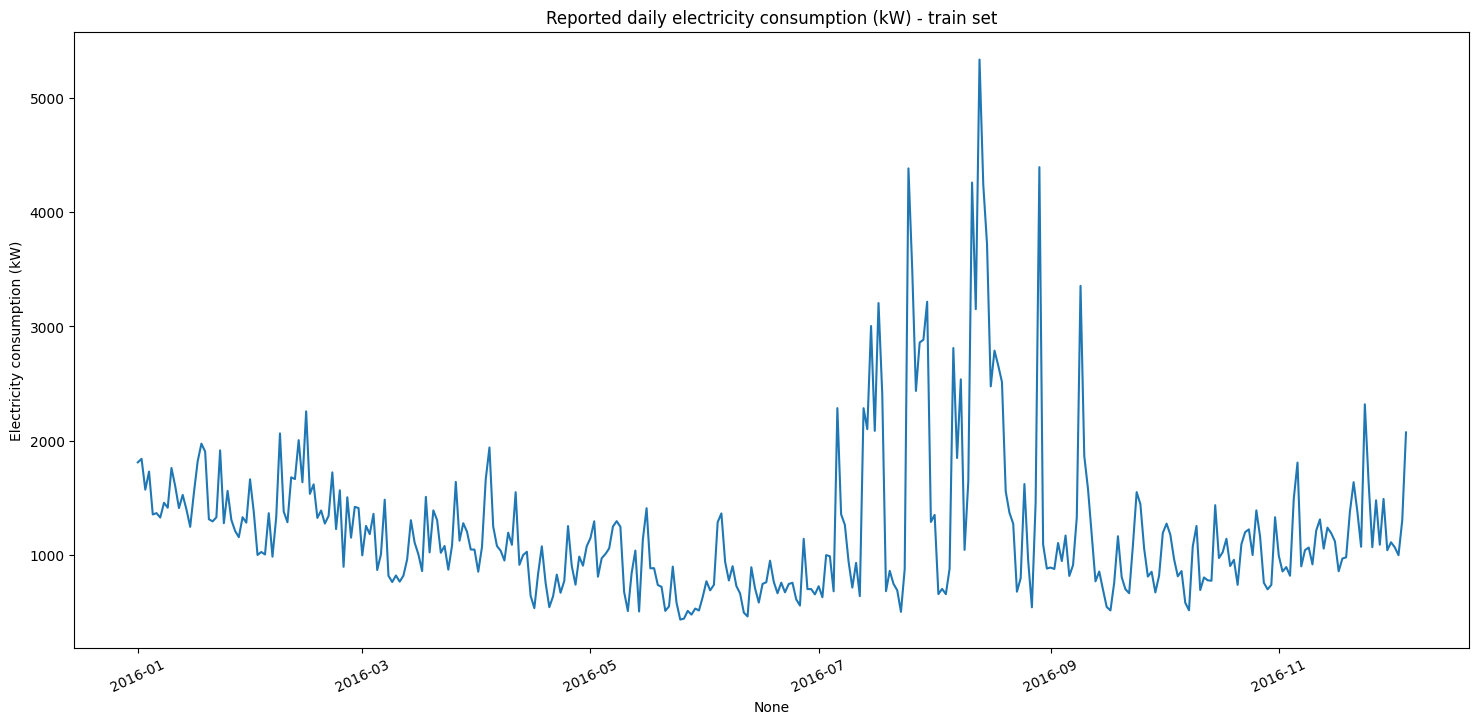

In [51]:
#splitting train and test data for arima model
PRED_WINDOW = 10
train_set, test_set = pm.model_selection.train_test_split(home_dataset_day, train_size=num_days - PRED_WINDOW)

# The indices for the train and test set
time_index_train = train_set.index
time_index_test = test_set.index

# Plot for reported daily electricity consumption
plt.figure()
sns.lineplot(x=time_index_train, y='Consumed energy', data=train_set)
plt.ylabel("Electricity consumption (kW)")
plt.title("Reported daily electricity consumption (kW) - train set")

plt.xticks(rotation = 25)
plt.show()

In [52]:
# Augmented Dickey-Fuller test
result = adfuller(train_set['Consumed energy'])
print(f'p-value of Augmented Dickey-Fuller test is {round(result[1],2)}')

p-value of Augmented Dickey-Fuller test is 0.04


In [53]:
model_name = 'ARIMA'
#using auto arima to find the best model
arima_model = auto_arima(train_set['Consumed energy'], start_p=1, start_q=1,
                             max_p=10, max_q=10, m=7,
                             start_P=0, seasonal=True,
                             d=None, D=None, trace=True,
                             error_action='ignore',
                             suppress_warnings=True, test="adf",
                             stepwise=True)

display(arima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[7] intercept   : AIC=5219.520, Time=0.38 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=5407.570, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=5220.353, Time=0.66 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=5282.992, Time=2.75 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=5898.206, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[7] intercept   : AIC=5222.662, Time=0.25 sec
 ARIMA(1,0,1)(1,0,1)[7] intercept   : AIC=5221.211, Time=1.20 sec
 ARIMA(1,0,1)(0,0,2)[7] intercept   : AIC=5217.461, Time=0.34 sec
 ARIMA(1,0,1)(1,0,2)[7] intercept   : AIC=5218.796, Time=0.80 sec
 ARIMA(0,0,1)(0,0,2)[7] intercept   : AIC=5270.292, Time=1.02 sec
 ARIMA(1,0,0)(0,0,2)[7] intercept   : AIC=5217.996, Time=0.29 sec
 ARIMA(2,0,1)(0,0,2)[7] intercept   : AIC=5219.462, Time=0.53 sec
 ARIMA(1,0,2)(0,0,2)[7] intercept   : AIC=5219.584, Time=0.48 sec
 ARIMA(0,0,0)(0,0,2)[7] intercept   : AIC=5383.508, Time=0.55 sec
 ARIMA(0,0,2)(0,0,2)[7] intercept

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                  340
Model:             SARIMAX(1, 0, 1)x(0, 0, [1, 2], 7)   Log Likelihood               -2602.730
Date:                                Sat, 16 Nov 2024   AIC                           5217.461
Time:                                        23:37:55   BIC                           5240.435
Sample:                                    01-01-2016   HQIC                          5226.615
                                         - 12-05-2016                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    361.4999     82.841      4.364      0.000     199.135     523.865
ar.L1          0.7104      0.048     14.674      0.000       0.616       0.805
ma.L1         -0.1348      0.062     -2.158      0.031      -0.257      -0.012
ma.S.L7        0.1026      0.048      2.133      0.033       0.008       0.197
ma.S.L14       0.1128      0.050      2.237      0.025       0.014       0.212
sigma2      2.692e+05   1.13e+04     23.757      0.000    2.47e+05    2.91e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3191.80
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               3.55   Skew:                             2.62
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

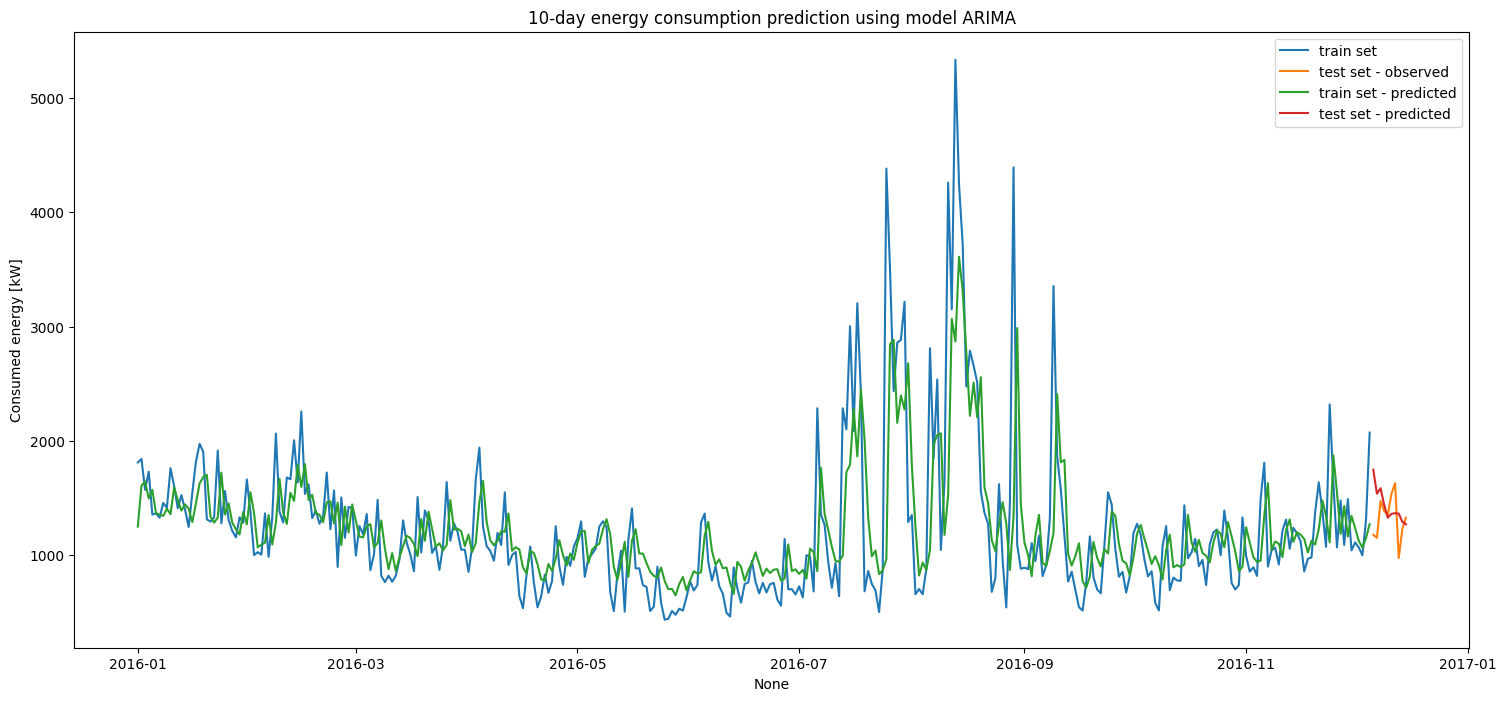

The RMSE of ARIMA on the test set is 273.41 kW


In [54]:
arima_preds = arima_model.predict(n_periods=PRED_WINDOW, return_conf_int=False)
#plotting the predicted data
train_set[model_name] = arima_model.predict_in_sample()
test_set[model_name] = arima_preds
plot_predicted_values(model_name)

# Calculate RMSE
error = round(np.sqrt(mean_squared_error(test_set['Consumed energy'], test_set[model_name])),2)
print(f'The RMSE of {model_name} on the test set is {error} kW')

In [55]:
from sklearn.metrics import mean_absolute_percentage_error

# Calculate MAPE using sklearn
mape = mean_absolute_percentage_error(test_set['Consumed energy'], test_set[model_name])

print(f'The MAPE of {model_name} on the test set is {round(mape * 100, 2)}%')

The MAPE of ARIMA on the test set is 17.2%


In [56]:
model_name = 'SARIMAX (mixed model)'

# using all weather conditionas as exogenous parameters
exo_train = train_set[weather_cols_cont]
exo_test = test_set[weather_cols_cont]

# To develop a mixed model, using the ARIMA(1,0,1)(0,0,2)[7] model from above
# and addimg all the weather conditions as exogenous variables
model = SARIMAX(
    train_set['Consumed energy'],
    exog = exo_train,
    order=(1,0,1),
    seasonal_order=(0,0,2,7),
    trend="n",
    enforce_stationarity=False,
    enforce_invertibility=False)

# Fit the model
model_fit = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


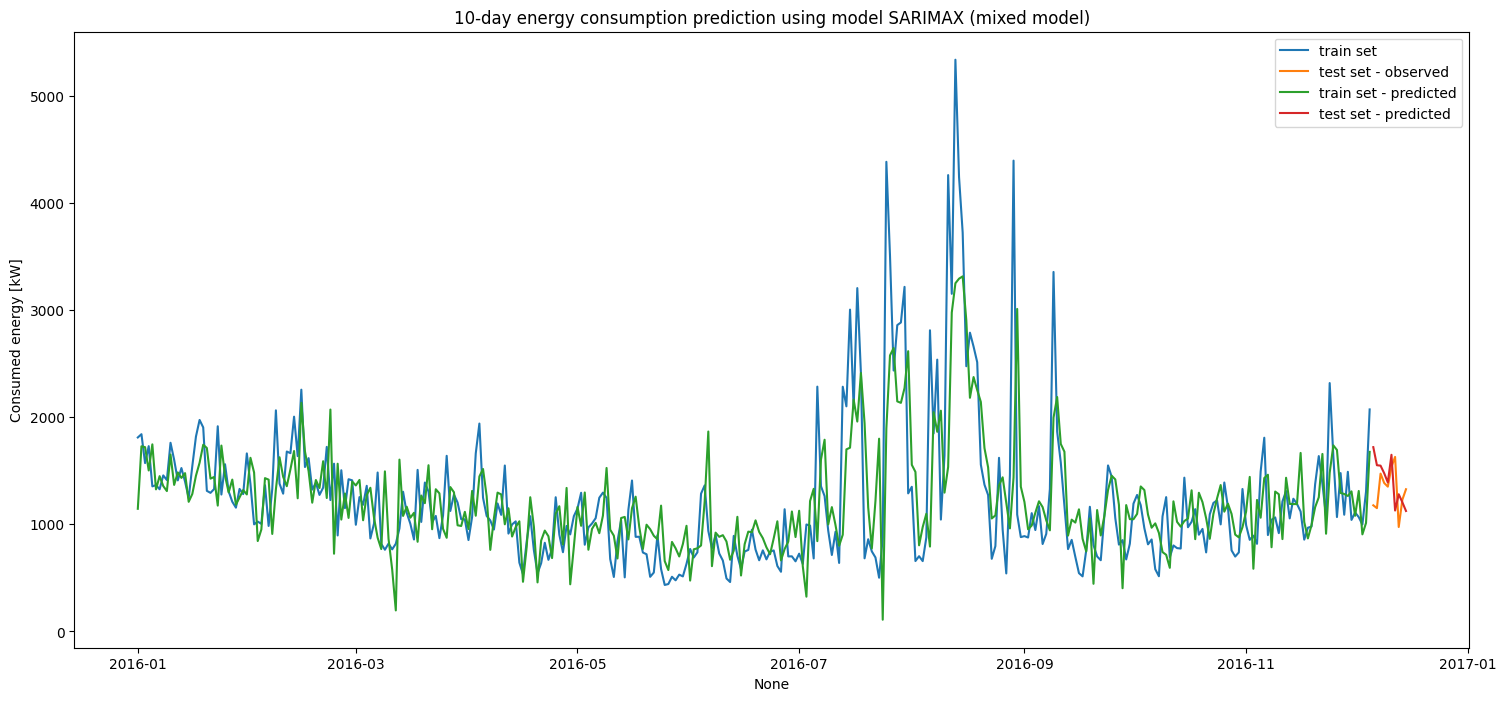

The RMSE of SARIMAX (mixed model) on the test set is 294.79 kW


In [57]:
train_set[model_name]=model_fit.get_prediction(start=0, dynamic=False).predicted_mean
test_set[model_name]=model_fit.get_forecast(steps=10, exog=exo_test).predicted_mean

plot_predicted_values(model_name)

# Calculate RMSE
error = round(np.sqrt(mean_squared_error(test_set['Consumed energy'], test_set[model_name])),2)
print(f'The RMSE of {model_name} on the test set is {error} kW')

In [58]:
from sklearn.metrics import mean_absolute_percentage_error

# Calculate MAPE using sklearn
mape = mean_absolute_percentage_error(test_set['Consumed energy'], test_set[model_name])

print(f'The MAPE of {model_name} on the test set is {round(mape * 100, 2)}%')


The MAPE of SARIMAX (mixed model) on the test set is 18.21%


K Means Clustering

In [59]:
scaled_data_train = np.nan_to_num(scaled_data_train)
scaled_data_test = np.nan_to_num(scaled_data_test)
#number of clusters=3
kmeans = KMeans(n_clusters=3, random_state=0)
clusters_train = kmeans.fit_predict(scaled_data_train)
clusters_test = kmeans.predict(scaled_data_test)


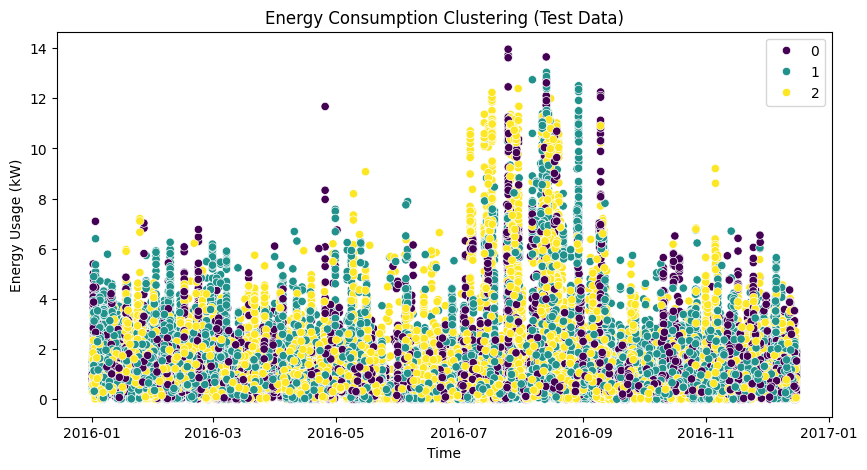

In [60]:
#plotting the clustered test data
plt.figure(figsize=(10, 5))
sns.scatterplot(x=X_test.index, y=y_test, hue=clusters_test, palette="viridis")
plt.title("Energy Consumption Clustering (Test Data)")
plt.xlabel("Time")
plt.ylabel("Energy Usage (kW)")
plt.show()

Random Forest

In [61]:
# Calculate the threshold for efficiency based on mean and standard deviation of 'use [kW]'
threshold = y.mean() + y.std()
# Create a new column 'efficiency' to classify based on the threshold
data['efficiency'] = np.where(data['use [kW]'] > threshold, 1, 0)
y_efficiency = data['efficiency']

# Split for classification
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X, y_efficiency, test_size=0.4, random_state=42)
#training the model
rf_model = RandomForestClassifier( n_estimators=5,max_depth=4,min_samples_split=15,min_samples_leaf=7,random_state=42)
rf_model.fit(X_train_class, y_train_class)
rf_preds = rf_model.predict(X_test_class)


In [62]:
# Classification metrics
rf_accuracy = accuracy_score(y_test_class, rf_preds)
print("Random Forest Classification Report:")
print(classification_report(y_test_class, rf_preds))
print(f"Random Forest Accuracy: {rf_accuracy * 100:.2f}%")

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98    188469
           1       0.97      0.29      0.45     13095

    accuracy                           0.95    201564
   macro avg       0.96      0.65      0.71    201564
weighted avg       0.95      0.95      0.94    201564

Random Forest Accuracy: 95.33%


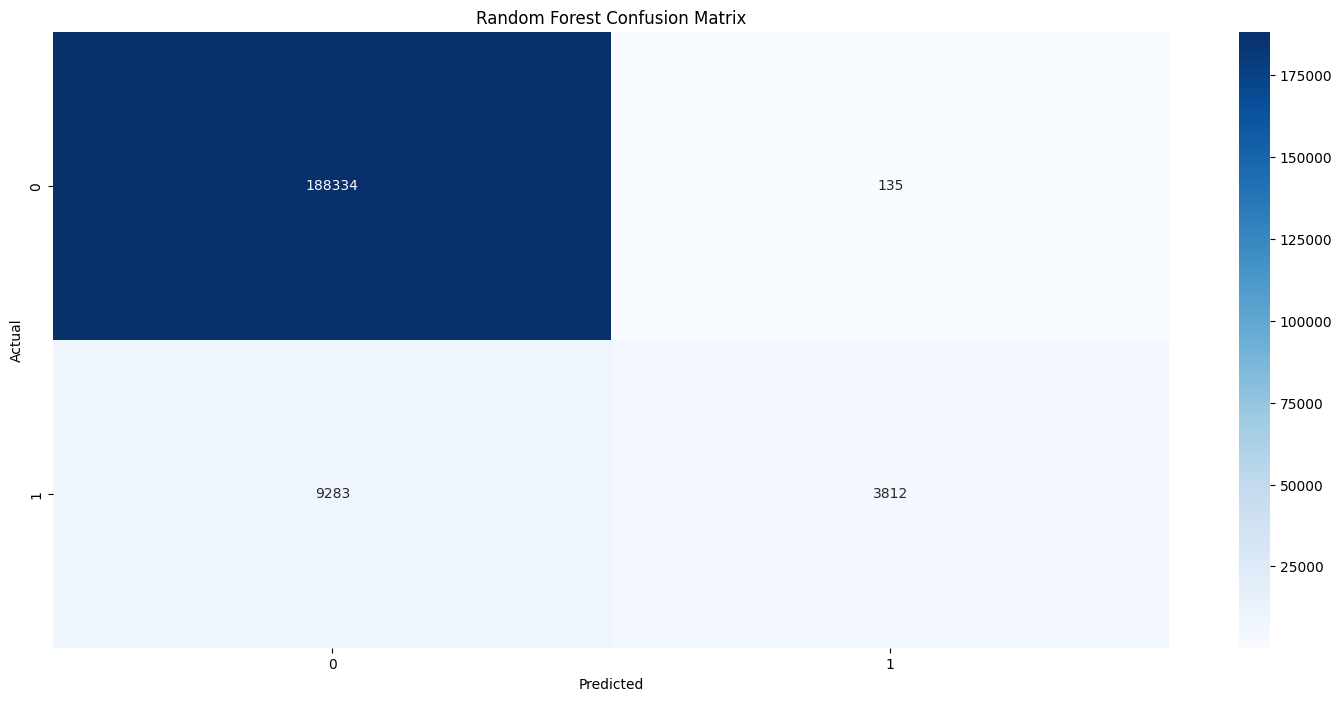

In [63]:
sns.heatmap(pd.crosstab(y_test_class, rf_preds, rownames=['Actual'], colnames=['Predicted']), annot=True, fmt="d", cmap="Blues")
plt.title("Random Forest Confusion Matrix")
plt.show()

In [65]:
# Summarize ARIMA results
print(f"ARIMA Model Results:")
print(f" - RMSE: {round(np.sqrt(mean_squared_error(test_set['Consumed energy'], test_set['ARIMA'])), 2)} kW")
print(f" - MAPE: {round(mean_absolute_percentage_error(test_set['Consumed energy'], test_set['ARIMA']) * 100, 2)}%\n")

# Summarize SARIMAX results
print(f"SARIMAX Model Results (with exogenous variables):")
print(f" - RMSE: {round(np.sqrt(mean_squared_error(test_set['Consumed energy'], test_set['SARIMAX (mixed model)'])), 2)} kW")
print(f" - MAPE: {round(mean_absolute_percentage_error(test_set['Consumed energy'], test_set['SARIMAX (mixed model)']) * 100, 2)}%\n")

# Summarize Clustering results
print(f"K-Means Clustering Results:")
print(f" - Number of clusters identified: {kmeans.n_clusters}")
print(" - Visualization shows distinct patterns in energy consumption.\n")

# Summarize Random Forest Classification results
print(f"Random Forest Classification Results:")
print(f" - Accuracy: {rf_accuracy * 100:.2f}%")
print(f" - Classification Report:\n{classification_report(y_test_class, rf_preds)}")


ARIMA Model Results:
 - RMSE: 273.41 kW
 - MAPE: 17.2%

SARIMAX Model Results (with exogenous variables):
 - RMSE: 294.79 kW
 - MAPE: 18.21%

K-Means Clustering Results:
 - Number of clusters identified: 3
 - Visualization shows distinct patterns in energy consumption.

Random Forest Classification Results:
 - Accuracy: 95.33%
 - Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98    188469
           1       0.97      0.29      0.45     13095

    accuracy                           0.95    201564
   macro avg       0.96      0.65      0.71    201564
weighted avg       0.95      0.95      0.94    201564

